In [15]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from sklearn.datasets import fetch_olivetti_faces
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = fetch_olivetti_faces()

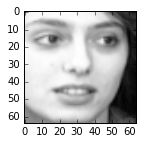

In [3]:
face_number = 79
plt.figure(figsize=(2.0, 2.26))
plt.imshow(data.images[face_number],
           cmap=plt.cm.gray)
plt.show()

In [ ]:
import keras
from keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D, Flatten
from keras.models import Model, Sequential
from keras.initializers import RandomNormal

In [ ]:
# Shared layers. This portion of the model will compute latent variables
# for each of the images to be compared in the next stage.
encode_image = Sequential()
encode_image.add(Conv2D(64, (9, 9), activation='relu', bias_initializer=RandomNormal(0.5, .01), input_shape=(64, 64)))
encode_image.add(MaxPooling2D((2, 2))) # 28x28
encode_image.add(Conv2D(128, (5, 5), activation='relu', bias_initializer=RandomNormal(0.0, .01)))
encode_image.add(MaxPooling2D((2, 2))) # 12x12
encode_image.add(Conv2D(128, (3, 3), activation='relu', bias_initializer=RandomNormal(0.0, .01)))
encode_image.add(MaxPooling2D((2, 2)))
encode_image.add(Conv2D(256, (4, 4), activation='relu', bias_initializer=RandomNormal(0.0, .01)))


Since the Olivetti face database is not large enough to do well training the network and the architecture of this netwrk is really optimized for character recognition, it probably makes more sense to use a pretrained face recognition network for encoding the images. The result of this encoding will then be compared between the two and the final stage will be trained to complete the discrimination.

The best choice for pretrained face recognition networks is probably the VGG-Face network, as described in this paper - http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf, which has already been converted to Keras here - https://gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9.

One difficulty may be the differning format between the VGG face dataset and the Olivetti set. To accomodate the different format and grayscale the Olivetti images will be adjusted to match the expected input with a similar placement of the face in the image and the grayscale repeated on all three rbg planes.

The VGG-Faces based siamese model will be fine tuned to the first 30 of the Olivetti faces and the remaining 10 will be used to test one-shot accuracy.

As I was trying to determine the way faces should be framed in the image I found this paper which describes adapting the VGG-Faces model for cross-over learning - http://cs231n.stanford.edu/reports/2016/pdfs/006_Report.pdf

It seems that the Olivetti faces are probably reasonably well cropped, so we will only need to change them to RGB format for the input.

In [4]:
def vgg_face(weights_path=None):
    img = Input(shape=(224, 224, 3))

    conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', trainable=False)(img)
    conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', trainable=False)(conv1_1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1', trainable=False)(conv1_2)

    conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', trainable=False)(pool1)
    conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', trainable=False)(conv2_1)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2', trainable=False)(conv2_2)

    conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', trainable=False)(pool2)
    conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', trainable=False)(conv3_1)
    conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', trainable=False)(conv3_2)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3', trainable=False)(conv3_3)

    conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', trainable=False)(pool3)
    conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', trainable=False)(conv4_1)
    conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', trainable=False)(conv4_2)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4', trainable=False)(conv4_3)

    conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', trainable=False)(pool4)
    conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', trainable=False)(conv5_1)
    conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', trainable=False)(conv5_2)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='pool5', trainable=False)(conv5_3)

    flat = Flatten()(pool5)
    fc6 = Dense(4096, activation='relu', name='fc6', trainable=False)(flat)
    fc7 = Dense(4096, activation='relu', name='fc7', trainable=False)(fc6)
    out = Dense(2622, activation='softmax', name='fc8')(fc7)

    model = Model(inputs=img, outputs=out)

    if weights_path:
        model.load_weights(weights_path)

    return model

# encode_image = vgg_face('rcmalli_vggface_tf_v2.h5')

In [5]:
encode_image.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [5]:
def convert_image(img):
    new_image = Image.fromarray(img).resize((224, 224))
    img = np.asarray(new_image)
    color_image = np.array([img, img, img])
    return transpose(color_image, (1, 2, 0))

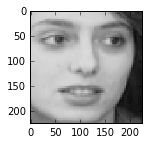

In [6]:
plt.figure(figsize=(2.0, 2.26))
plt.imshow(convert_image(data.images[79]))
plt.show()

I was looking for how to merge the results form the twins and found this blog post on how someone implemented the model in the paper - https://sorenbouma.github.io/blog/oneshot/ So, some of the following code is adapted from that. Unfortunately, I found his code fairly opaque, due to minimal comments or whitespace, but I did get some clues from it.

In [11]:
def get_branch_model():
    # Set up VGG-Face network and load weights.
    encode_image = vgg_face('rcmalli_vggface_tf_v2.h5')

    # Strip off the final layer used for prediction, leaving the image feature vector.
    # Unfortunately, popping off layers still does not work correctly. After popping
    # you still need to reassign the output of the model to the final layer or it will
    # still be trying to look at the old final layer. See here - https://github.com/fchollet/keras/issues/2371
    # encode_image.layers.pop()
    encode_image.layers.pop()
    encode_image.outputs = [encode_image.layers[-1].output]
    encode_image.layers[-1].outbound_nodes = []

    return encode_image

In [12]:
encode = get_branch_model()

In [13]:
encode.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [16]:
optimizer = Adam(0.00006)
encode.compile(loss="binary_crossentropy", optimizer=optimizer)

In [17]:
images = np.zeros((400, 224, 224, 3))
for i in range(400):
    images[i, :, :, :] = convert_image(data.images[i])

In [19]:
vectors = encode.predict(images[:16], batch_size = 16)
for i in range(24):
    vectors = np.concatenate((vectors, encode.predict(images[16*(i+1):16*(i+2)], batch_size = 16)))

In [21]:
vectors.shape

(400, 4096)

In [27]:
print(vectors[20:40, 30:36])

[[ 0.          0.02642416  0.01712929  0.          0.          0.        ]
 [ 0.          0.          0.0100847   0.          0.          0.        ]
 [ 0.          0.0043798   0.          0.          0.          0.        ]
 [ 0.          0.00726469  0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.01590716  0.          0.          0.          0.        ]
 [ 0.          0.03807902  0.          0.          0.          0.        ]
 [ 0.          0.01726065  0.          0.          0.          0.        ]
 [ 0.          0.05755867  0.          0.          0.          0.        ]
 [ 0.          0.0638838   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.        

### If we use 75% of the Olivetti Faces data set for training, the number of positive and negative pairs we can get is 9X5X30 = 1350 and 150x290 = 43,500.
We will draw evenly and randomly from those sets for training batches and run until we are not seeing much additional improvement.
For validation we will have 450 positive cases and 4500 negative cases. To do this more rigorously we would optimize the model to perform well on half of these data, using 5 of the remaining individuals, and validate that on the final 5. This gives us 10!/(5!x5!) = 252 ways to do the test and validate groups. 

In [29]:
# Randomly choose 75% of the indices for the Olivetti subjects for the training set.
train = np.random.choice(range(40), 30, replace=False)
# Take the remaining 25% for the test set.
test = np.array([idx for idx in range(40) if idx not in train])

In [44]:
from itertools import combinations
# Pairs of indices for images of the same subject.
test_pairs_pos = np.concatenate([np.array(list(combinations(range(10), 2)))+idx*10 for idx in test])

In [45]:
train_pairs_pos = np.concatenate([np.array(list(combinations(range(10), 2)))+idx*10 for idx in train])

In [54]:
def random_neg_pair(subject_indices):
    """Takes an array of subject indices and returns a pair of indices to non-matching image vectors."""
    subject = random.choice(subject_indices)
    ind1 = 10*subject + random.choice(range(10))
    others = subject_indices.tolist()
    others.remove(subject)
    ind2 = 10*random.choice(others) + random.choice(range(10))
    return [ind1, ind2]

def draw_random_neg_pairs(subject_indices, number):
    """Returns a set of number unique negative pairs"""
    pairs = []
    while (len(pairs) < number):
        pair = set(random_neg_pair(subject_indices))
        if pair not in pairs:
            pairs.append(pair)
    return np.array([list(s) for s in pairs])

In [55]:
train_pairs_neg = draw_random_neg_pairs(train, 1350)

In [58]:
train_pairs_neg[5:10]

array([[  1,  69],
       [ 10,  35],
       [218, 190],
       [218,  87],
       [329, 203]])

In [8]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
from keras.initializers import TruncatedNormal
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

input_shape = (224, 224, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# Set up VGG-Face network and load weights.
encode_image = vgg_face('rcmalli_vggface_tf_v2.h5')

# Strip off the final two layers used for prediction, leaving the image feature vector.
# Unfortunately, popping off layers still does not work correctly. After popping
# you still need to reassign the output of the model to the final layer or it
# still be trying to look at the old final layer. See here - https://github.com/fchollet/keras/issues/2371
encode_image.layers.pop()
encode_image.outputs = [encode_image.layers[-1].output]
encode_image.layers[-1].outbound_nodes = []

# Encode each of the two inputs into a vector with the convnet.
branch_l = encode_image(left_input)
branch_r = encode_image(right_input)

# Merge two encoded inputs with the L1 distance between them.
both = Lambda(lambda x: np.abs(x[0]-x[1]), output_shape=lambda x: x[0].shape)([branch_l, branch_r])
# Make the final prediction layer as described in the paper. This is the only layer we will train to begin with.
prediction = Dense(1, activation='sigmoid', bias_initializer=TruncatedNormal(mean=0.5, stddev=0.01))(both)
siamese_net = Model([left_input, right_input], prediction)

In [ ]:
discrim_input = Input((2, 4096))
# Merge two encoded inputs with the L1 distance between them.
both = Lambda(lambda x: np.abs(x[0]-x[1]), output_shape=lambda x: x[0].shape)(discrim_input)
# Make the final prediction layer as described in the paper. This is the only layer we will train to begin with.
# We can unfreeze additional fc layers and train them if it seems to be needed.
prediction = Dense(1, activation='sigmoid', bias_initializer=TruncatedNormal(mean=0.5, stddev=0.01))(both)
discriminator = Model(inputs=discrim_input, outputs=prediction)

In [9]:
optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paper working
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)

siamese_net.count_params()

134264641

In [10]:
siamese_net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
input_11 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
model_1 (Model)                  multiple              134260544   input_10[0][0]                   
                                                                   input_11[0][0]                   
____________________________________________________________________________________________________
lambda_4 (Lambda)                (None, 4096)          0           model_1[4][0]           

In [ ]:
WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_v2.h5'

class Siamese_Face_Tester(object):
    """Loads Olivetti Face data and generates sets for training and testing one-shot learning on Siamese Network."""
    def __init__(self):
        self.train, self.test = self.new_train_test_split()
        # Pairs of indices for images of the same subject.
        self.test_pairs_pos, self.train_pairs_pos = get_pos_pairs()
        # Train and test sets for training the discriminator.
        self.train_pairs = []
        self.train_target = []
        self.test_pairs = []
        self.test_target = []
        self.refresh_train_sets()
        # Fetch and convert Olivetti Face data.
        self.data = fetch_olivetti_faces()
        self.images = np.zeros((400, 224, 224, 3))
        for i in range(400):
            self.images[i, :, :, :] = self.convert_image(self.data.images[i])
        self.image_vectors = None
        self.branch_encoder = None
        self.weights_path = None
        self.discriminator = self.get_discriminator()


    def convert_image(self, img):
        """Convert gray scale image to color in [h, w, channels] format."""
        new_image = Image.fromarray(img).resize((224, 224))
        img = np.asarray(new_image)
        color_image = np.array([img, img, img])
        return transpose(color_image, (1, 2, 0))


    def new_train_test_split(self):
        """Olivetti Faces includes 40 sets of 10 images. This returns a 75/25 random split of 40 indices."""
        # Randomly choose 75% of the indices for the Olivetti subjects for the training set.
        train = np.random.choice(range(40), 30, replace=False)
        # Take the remaining 25% for the test set.
        test = np.array([idx for idx in range(40) if idx not in train])
        return train, test


    def get_pos_pairs(self):
        """Returns all possible positive pairs for the current train-test split."""
        test_pairs_pos = np.concatenate([np.array(list(combinations(range(10), 2)))+idx*10 for idx in self.test])
        train_pairs_pos = np.concatenate([np.array(list(combinations(range(10), 2)))+idx*10 for idx in self.train])
        return test_pairs_pos, train_pairs_pos


    def refresh_train_sets(self, batch_size=32):
        """Refreshes the train and test sets of index pairs and targets with a new random draw of negative pairs."""
        # Make the train set an integer multiple of the batch size (not sure if this matters...)
        drop = len(self.train_pairs_pos)%batch_size
        train_pairs = np.concatenate((self.train_pairs_pos[:-drop], draw_random_neg_pairs(self.train, len(self.train_pairs_pos)-drop)))
        train_targets = np.concatenate((np.ones(len(train_pairs)/2), np.zeros(len(train_pairs)/2)))
        train_labeled = np.array([train_pairs, train_targets]).T
        np.random.shuffle(train_labeled)
        [self.train_pairs, self.train_target] = train_labeled.T
        # Repeat same procedure for the test set. Clearly could be refactored in some way, but no time now.
        drop = len(self.test_pairs_pos)%batch_size
        test_pairs = np.concatenate((self.test_pairs_pos[:-drop], draw_random_neg_pairs(self.test, len(self.test_pairs_pos)-drop)))
        test_targets = np.concatenate((np.ones(len(test_pairs)/2), np.zeros(len(test_pairs)/2)))
        test_labeled = np.array([test_pairs, test_targets]).T
        np.random.shuffle(test_labeled)
        [self.test_pairs, self.test_target] = test_labeled.T
        
        """The test set accuracy during training is equivalent to a one-out-of-two one-shot learning task averaged over the all test data."""
        

    def random_neg_pair(self, subject_indices):
        """Takes an array of subject indices and returns a pair of indices to non-matching image vectors."""
        subject = random.choice(subject_indices)
        ind1 = 10*subject + random.choice(range(10))
        others = subject_indices.tolist()
        others.remove(subject)
        ind2 = 10*random.choice(others) + random.choice(range(10))
        return [ind1, ind2]


    def draw_random_neg_pairs(self, subject_indices, number):
        """Returns a set of number unique negative pairs"""
        pairs = []
        while (len(pairs) < number):
            pair = set(random_neg_pair(subject_indices))
            if pair not in pairs:
                pairs.append(pair)
        return np.array([list(s) for s in pairs])


    def vgg_face(self, weights_path=None):
        img = Input(shape=(224, 224, 3))

        conv1_1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', trainable=False)(img)
        conv1_2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', trainable=False)(conv1_1)
        pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1', trainable=False)(conv1_2)

        conv2_1 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', trainable=False)(pool1)
        conv2_2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', trainable=False)(conv2_1)
        pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2', trainable=False)(conv2_2)

        conv3_1 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', trainable=False)(pool2)
        conv3_2 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', trainable=False)(conv3_1)
        conv3_3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', trainable=False)(conv3_2)
        pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3', trainable=False)(conv3_3)

        conv4_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', trainable=False)(pool3)
        conv4_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', trainable=False)(conv4_1)
        conv4_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', trainable=False)(conv4_2)
        pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4', trainable=False)(conv4_3)

        conv5_1 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', trainable=False)(pool4)
        conv5_2 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', trainable=False)(conv5_1)
        conv5_3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', trainable=False)(conv5_2)
        pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='pool5', trainable=False)(conv5_3)

        flat = Flatten()(pool5)
        fc6 = Dense(4096, activation='relu', name='fc6', trainable=False)(flat)
        fc7 = Dense(4096, activation='relu', name='fc7', trainable=False)(fc6)
        out = Dense(2622, activation='softmax', name='fc8')(fc7)

        model = Model(inputs=img, outputs=out)

        if weights_path:
            model.load_weights(weights_path)

        return model


    def get_branch_model(self):
        """Returns a model that can be used to encode images into vectors using the trained VGG-Face model."""
        if self.branch_encoder == None:
            # Set up VGGFace network and load weights.
            if self.weights_path == None:
                self.get_VGG_weights()
            encode_image = vgg_face(self.weights_path)

            # Strip off the final layer used for prediction, leaving the image feature vector.
            # Unfortunately, popping off layers still does not work correctly. After popping
            # you still need to reassign the output of the model to the final layer or it will
            # still be trying to look at the old final layer. See here - https://github.com/fchollet/keras/issues/2371
            encode_image.layers.pop()
            encode_image.outputs = [encode_image.layers[-1].output]
            encode_image.layers[-1].outbound_nodes = []
            self.branch_encoder = encode_image
        return self.branch_encoder
    
    
    def encode_image_vectors(self):
        """Uses the image encoding branch to turn the Olivetti images into vectors."""
        encoder = self.get_branch_model()
        vectors = encoder.predict(self.images[:16], batch_size = 16)
        for i in range(24):
            vectors = np.concatenate((vectors, encoder.predict(self.images[16*(i+1):16*(i+2)], batch_size = 16)))
        return vectors


    def get_image_vectors(self):
        """Returns the image vectors, computing them if necessary."""
        if self.image_vectors == None:
            self.image_vectors = self.encode_image_vectors()
        return self.image_vectors
    
    
    def get_VGG_weights(self):
        """Download VGGFace weights if they are not present."""
        self.weights_path = get_file('rcmalli_vggface_tf_v2.h5',
                                     WEIGHTS_PATH,
                                     cache_subdir='models')
        
        
    def get_discriminator(self):
        """The discriminator is the part of the siamese network that we will train to tell the difference between encoded image vectors."""
        discrim_input = Input((2, 4096))
        # Merge two encoded inputs with the L1 distance between them.
        both = Lambda(lambda x: np.abs(x[0]-x[1]), output_shape=lambda x: x[0].shape)(discrim_input)
        # Make the final prediction layer as described in the paper. This is the only layer we will train to begin with.
        # We can unfreeze additional fc layers and train them if it seems to be needed.
        prediction = Dense(1, activation='sigmoid', bias_initializer=TruncatedNormal(mean=0.5, stddev=0.01))(both)
        discriminator = Model(inputs=discrim_input, outputs=prediction)
        return discriminator

In [ ]:
tester = Siamese_Face_Tester()
vectors = tester.get_image_vectors()
tester.discriminator.compile(loss="binary_crossentropy", optimizer=Adam)
X_train = [[vectors[pair[0]], vectors[pair[1]]] for pair in tester.train_pairs]
X_test = [[vectors[pair[0]], vectors[pair[1]]] for pair in tester.test_pairs]
tester.fit(x=X_train, y=tester.train_target, validation_data=(X_test, tester.test_target))

In [ ]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, Xtrain, Xval):
        self.Xval = Xval
        self.Xtrain = Xtrain
        self.n_classes, self.n_examples, self.w, self.h = Xtrain.shape
        self.n_val, self.n_ex_val, _, _ = Xval.shape

    def get_batch(self,n):
        """Create batch of n pairs, half same class, half different class"""
        categories = rng.choice(self.n_classes, size=(n,), replace=False)
        pairs=[np.zeros((n, self.h, self.w, 1)) for i in range(2)]
        targets=np.zeros((n, ))
        targets[n//2:] = 1
        for i in range(n):
            category = categories[i]
            idx_1 = rng.randint(0, self.n_examples)
            pairs[0][i, :, :, :] = self.Xtrain[category, idx_1].reshape(self.w, self.h,1)
            idx_2 = rng.randint(0, self.n_examples)
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i >= n//2 else (category + rng.randint(1, self.n_classes)) % self.n_classes
            pairs[1][i, :, :, :] = self.Xtrain[category_2, idx_2].reshape(self.w, self.h,1)
        return pairs, targets

    def make_oneshot_task(self,N):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        categories = rng.choice(self.n_val,size=(N,),replace=False)
        indices = rng.randint(0,self.n_ex_val,size=(N,))
        true_category = categories[0]
        ex1, ex2 = rng.choice(self.n_examples,replace=False,size=(2,))
        test_image = np.asarray([self.Xval[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = self.Xval[categories,indices,:,:]
        support_set[0,:,:] = self.Xval[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        pairs = [test_image,support_set]
        targets = np.zeros((N,))
        targets[0] = 1
        return pairs, targets

    def test_oneshot(self,model,N,k,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        pass
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N)
            probs = model.predict(inputs)
            if np.argmax(probs) == 0:
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

In [ ]:
evaluate_every = 7000
loss_every=300
batch_size = 32
N_way = 20
n_val = 550
siamese_net.load_weights("PATH")
best = 76.0
for i in range(900000):
    (inputs, targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net, N_way, n_val, verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save('PATH')
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

Seems that for training the final layer it may be faster to precompute the output of the VGG-Face branches for all the images and train the final layer on its own. I will see if I can figure out how to do that once I have things set up.

To multiply the amount of data we have we migth also just do some transformations on the image vectors for training the final layer rather than on the original images. Perhaps a dropout of 10% of the components. If we were to start from the original images we could add noise or perform affine distortions that approximate changes in the angle of the photo or lighting without creating abnormal facial shapes.

### Improved source for VGG-Face
After muching around with VGG-Face trying to get it to work I think I found a better source for a Keras-based VGG-Face model ready for fine tuning here - https://github.com/rcmalli/keras-vggface